In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas.plotting import parallel_coordinates
from matplotlib.colors import ListedColormap
import matplotlib.ticker as tick

In [2]:
#sns.set_context("paper")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)

sns.set(font='serif')
sns.set_style("ticks")

In [39]:
# Load and prepare data

basic = pd.read_csv("data/rerun/output/articles_metadata.csv", index_col="pmid")
funding = pd.read_csv("data/rerun/output/articles_funding_dummies.csv", index_col="pmid")
mesh = pd.read_csv("data/rerun/output/articles_mesh_term_dummies.csv", index_col="pmid")
mesh_subterm = pd.read_csv("data/rerun/output/articles_mesh_subterm_dummies.csv", index_col="pmid")
news = pd.read_csv("data/rerun/output/articles_news_coverage.csv", index_col="pmid")

# Convert to binary columns to bool
funding = funding.apply(lambda x: x==1)
mesh = mesh.apply(lambda x: x==1)
mesh_subterm = mesh_subterm.apply(lambda x: x==1)
news[['news_mention', 'tier1','tier2','tier3','tier4']] = news[['news_mention', 'tier1','tier2','tier3','tier4']].apply(lambda x: x==1)

# Several views of the dataset
us_funding = funding.us_gov_funding == 1
news_mentions = news.news_count > 0
most_f_cancers = mesh[us_funding].sum().sort_values(ascending=False)
mapping = {cancer: i for i, cancer in enumerate(most_f_cancers.keys())}

## Boxplot of mentions

In [54]:
labels = {'Breast Neoplasms':'Breast',
          'Lung Neoplasms':'Lung',
          'Prostatic Neoplasms':'Prostatic',
          'Leukemia':'Leukemia',
          'Colorectal Neoplasms':'Colon',
          'Pancreatic Neoplasms':'Pancreatic',
          'Melanoma':'Melanoma',
          'Liver Neoplasms':'Liver',
          'Lymphoma, Non-Hodgkin':'Lymphoma, NH',
          'Kidney Neoplasms':'Kidney',
          'Endometrial Neoplasms':'Endometrial',
          'Thyroid Neoplasms':'Thyroid',
          'Urinary Bladder Neoplasms':'Urinary/Bladder'}

def shorten_cancers(cols):
    return [labels[x] for x in cols]

def update_mentions(row):
    for col in mesh.columns:
        if row[col]:
            row[col] = row['news_count']
        else:
            row[col] = None
    return row

In [55]:
df = news[['news_count']].merge(mesh, left_index=True, right_index=True)
df = df[us_funding]
df = df.apply(update_mentions, axis=1)[most_f_cancers.keys()]
df = df.replace(0, np.nan)

df.columns = shorten_cancers(df.columns)
pdf = df.melt(value_name="mentions", var_name="cancer").dropna()

total_mentions = df.sum()
desc = df.describe()
y_max = max(desc.loc['75%'] + 1.5 * (desc.loc['75%'] - desc.loc['25%']))

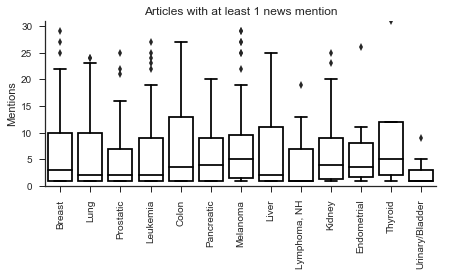

In [56]:
title = "Articles with at least 1 news mention"
ylabel = "Mentions"

figsize = (6.4, 4)
fig, ax = plt.subplots(figsize=figsize)
sns.boxplot(x="cancer", y="mentions", data=pdf, palette=cp, ax=ax)

# Scale and ticks
plt.ylim(0,y_max);
plt.xticks(rotation=90);

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')

# Set labels
ax.set_title(title)
ax.xaxis.label.set_visible(False)
ax.set_ylabel(ylabel)

# Savefig
plt.tight_layout()
fig.savefig("boxplots.png", dpi=300)

## Plot - Rank Parallel Coordinates

How do the different cancers' ranks compare across:

- number of funded articles
- estimated new cases
- estimated deaths
- estimated funding

Set `add_news_mentions = True` to add the ranks by average news mentions

In [9]:
add_news_mentions = True
plot_legend = False

In [10]:
est_new = [255190, 222500, 135430, 62130, 161360, 53670, 40710, 87110, 72240, 63990, 61380, 56870, 79030]
est_death = [41070, 155870, 50260, 24500, 26730, 43090, 28920, 9730, 20140, 14400, 10920, 2010, 16870]
est_fund = [543.7,256.2,209.3,246.9,228.9,125.3,70.3,132.8,122.4,None,None,None,None]

df = mesh[us_funding]
plot_df = pd.DataFrame({'Articles':most_f_cancers.tolist(),
                        'New cases': est_new,
                        'Deaths': est_death,
                        'Mentions': total_mentions.tolist()}, index=most_f_cancers.keys())

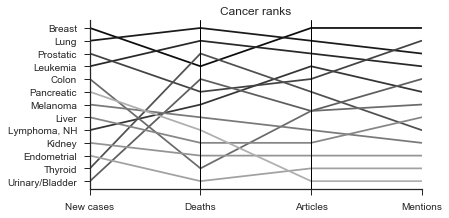

In [21]:
title = "Cancer ranks"
cp = sns.color_palette("binary", 18)
cm = ListedColormap(cp[::-1][:13])

if add_news_mentions:
    plotcols = ['New cases', 'Deaths', 'Articles', 'Mentions']
else:
    plotcols = ['Articles', 'Est. new cases', 'Est. deaths',]
ranks = plot_df[plotcols].rank(ascending=False).reset_index()
loc = tick.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals

figsize = (6.4, 3.2)
fig, ax = plt.subplots(figsize=figsize)
parallel_coordinates(ranks, 'index', colormap=cm, ax=ax)

plt.yticks(range(1,14))

ax.invert_yaxis()
if plot_legend:
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
else:
    def mjrFormatter(x, pos):
        return "{}".format(labels[most_f_cancers.keys().tolist()[pos]])
    ax.yaxis.set_major_formatter(tick.FuncFormatter(mjrFormatter))
    ax.legend_.remove()
    
# Hide the right and top spines
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set labels
ax.set_title(title)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)

# Savefig
plt.tight_layout()
fig.savefig("ranks.png", dpi=300)

# Plot - Stacked bar plot of stages of cancer

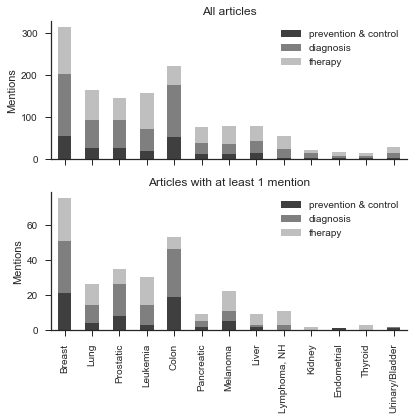

In [52]:
titles = ["All articles", "Articles with at least 1 mention"]
cp = sns.color_palette("binary", 3)
cm = ListedColormap(cp[::-1])

df = mesh.copy()
df.columns = shorten_cancers(df.columns)
df = df.merge(mesh_subterm, left_index=True, right_index=True)
df = df[us_funding]

fig, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True)
for i, ax in enumerate(axes):
    pdf = df
    if i == 1:
        pdf = pdf[news_mentions.reindex(df.index)]
    pdf = pdf.melt(id_vars=mesh_subterm.columns, var_name="cancer_type")
    pdf = pdf[pdf.value]
    pdf = pdf.groupby(["cancer_type"])[['prevention & control', 'diagnosis', 'therapy']].sum()
    # pdf = pdf.groupby(["cancer_type"])[['prevention & control', 'diagnosis', 'therapy']].apply(lambda x: 100*x.sum()/len(x))
    
    pdf = pdf.loc[[labels[x] for x in most_f_cancers.keys().tolist()]]
    
    pdf.plot(kind="bar", stacked=True, ax=ax, colormap=cm)
    
    ax.set_title(titles[i])
    
    # Hide the right and top spines
    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel("Mentions")
    
plt.tight_layout()
# Savefig
fig.savefig("bars.png", dpi=200)

## Correlation plots for the previous data

- funded articles
- estimated new cases
- estimated deaths
- estimated funding
- average news mentions

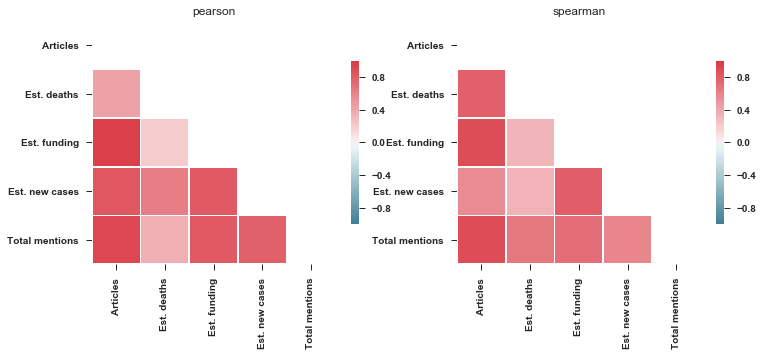

In [235]:
f, axes = plt.subplots(1, 2)
methods = ["pearson", "spearman"]
for ax, method in zip(axes, methods):
    corr = plot_df.corr(method=method)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title(method)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)